In [70]:
import itertools
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix
from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

import tensorflow as tf
np.random.seed(42)
tf.random.set_seed(42)
from keras import backend as K
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout

import warnings
warnings.filterwarnings("ignore")

## Importing Data

In [34]:
# Importing Domain Expert Designed Feature names

features = list()

with open("/content/drive/MyDrive/AAIC/Case Studies/Human Activity Recognition/UCI_HAR_Dataset/features.txt") as f:
  features = [line.split()[1] for line in f.readlines()]

print(f"Number of Features: {len(features)}")

Number of Features: 561


In [31]:
features_no_dup = []
for feature in features:
  if feature not in features_no_dup:
    features_no_dup.append(feature)
len(features_no_dup)

477

Each Time Series Data from Accelerometer and Gyroscope is divided into windows of length 128 with 50% overlap. 

In [41]:
# Loading Train Data
X_train = pd.read_csv('/content/drive/MyDrive/AAIC/Case Studies/Human Activity Recognition/UCI_HAR_Dataset/train/X_train.txt', delim_whitespace=True, header=None)
X_train.columns = features

# Getting Subject Data
X_train['subject'] = pd.read_csv("/content/drive/MyDrive/AAIC/Case Studies/Human Activity Recognition/UCI_HAR_Dataset/train/subject_train.txt",header = None, squeeze = True)

y_train = pd.read_csv("/content/drive/MyDrive/AAIC/Case Studies/Human Activity Recognition/UCI_HAR_Dataset/train/y_train.txt", names = ["Activity"], squeeze = True)
y_train_labels = y_train.map({1: 'WALKING', 2:'WALKING_UPSTAIRS',3:'WALKING_DOWNSTAIRS',4:'SITTING', 5:'STANDING',6:'LAYING'})

In [42]:
train = X_train
train["Activity"] = y_train
train["ActivityName"] = y_train_labels
train.sample()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,tBodyAcc-max()-Y,tBodyAcc-max()-Z,tBodyAcc-min()-X,tBodyAcc-min()-Y,tBodyAcc-min()-Z,tBodyAcc-sma(),tBodyAcc-energy()-X,tBodyAcc-energy()-Y,tBodyAcc-energy()-Z,tBodyAcc-iqr()-X,tBodyAcc-iqr()-Y,tBodyAcc-iqr()-Z,tBodyAcc-entropy()-X,tBodyAcc-entropy()-Y,tBodyAcc-entropy()-Z,"tBodyAcc-arCoeff()-X,1","tBodyAcc-arCoeff()-X,2","tBodyAcc-arCoeff()-X,3","tBodyAcc-arCoeff()-X,4","tBodyAcc-arCoeff()-Y,1","tBodyAcc-arCoeff()-Y,2","tBodyAcc-arCoeff()-Y,3","tBodyAcc-arCoeff()-Y,4","tBodyAcc-arCoeff()-Z,1","tBodyAcc-arCoeff()-Z,2","tBodyAcc-arCoeff()-Z,3","tBodyAcc-arCoeff()-Z,4","tBodyAcc-correlation()-X,Y","tBodyAcc-correlation()-X,Z","tBodyAcc-correlation()-Y,Z",...,fBodyBodyAccJerkMag-maxInds,fBodyBodyAccJerkMag-meanFreq(),fBodyBodyAccJerkMag-skewness(),fBodyBodyAccJerkMag-kurtosis(),fBodyBodyGyroMag-mean(),fBodyBodyGyroMag-std(),fBodyBodyGyroMag-mad(),fBodyBodyGyroMag-max(),fBodyBodyGyroMag-min(),fBodyBodyGyroMag-sma(),fBodyBodyGyroMag-energy(),fBodyBodyGyroMag-iqr(),fBodyBodyGyroMag-entropy(),fBodyBodyGyroMag-maxInds,fBodyBodyGyroMag-meanFreq(),fBodyBodyGyroMag-skewness(),fBodyBodyGyroMag-kurtosis(),fBodyBodyGyroJerkMag-mean(),fBodyBodyGyroJerkMag-std(),fBodyBodyGyroJerkMag-mad(),fBodyBodyGyroJerkMag-max(),fBodyBodyGyroJerkMag-min(),fBodyBodyGyroJerkMag-sma(),fBodyBodyGyroJerkMag-energy(),fBodyBodyGyroJerkMag-iqr(),fBodyBodyGyroJerkMag-entropy(),fBodyBodyGyroJerkMag-maxInds,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity,ActivityName
7124,0.362596,-0.036061,-0.230263,-0.421467,-0.103392,-0.077851,-0.470531,-0.047982,-0.048378,-0.247229,-0.121516,-0.378488,0.413408,0.334333,0.313967,-0.155857,-0.829862,-0.843486,-0.59593,-0.587544,-0.207431,0.000252,0.399282,0.128722,-0.121746,-0.825542,0.663497,-0.356603,0.167876,-0.463647,0.303862,-0.068063,0.129053,-0.652669,0.493682,-0.529125,0.362162,-0.291259,-0.286333,-0.532276,...,-0.936508,-0.096577,-0.280671,-0.597758,-0.629175,-0.213509,-0.438877,-0.016826,-0.992093,-0.629175,-0.733587,-0.685717,0.23659,-0.897436,-0.596781,0.770359,0.679293,-0.834701,-0.846283,-0.816847,-0.882011,-0.940413,-0.834701,-0.985891,-0.812876,0.025113,-0.84127,-0.136403,-0.468159,-0.822172,-0.313195,0.257224,-0.642037,0.066189,-0.765578,0.255273,0.058342,30,2,WALKING_UPSTAIRS


In [43]:
train.shape

(7352, 564)

### Loading Test Data

In [44]:
# Loading Test Data
X_test = pd.read_csv('/content/drive/MyDrive/AAIC/Case Studies/Human Activity Recognition/UCI_HAR_Dataset/test/X_test.txt', delim_whitespace=True, header=None)
X_test.columns = features

# Getting Subject Data
X_test['subject'] = pd.read_csv("/content/drive/MyDrive/AAIC/Case Studies/Human Activity Recognition/UCI_HAR_Dataset/test/subject_test.txt",header = None, squeeze = True)

y_test = pd.read_csv("/content/drive/MyDrive/AAIC/Case Studies/Human Activity Recognition/UCI_HAR_Dataset/test/y_test.txt", names = ["Activity"], squeeze = True)
y_test_labels = y_test.map({1: 'WALKING', 2:'WALKING_UPSTAIRS',3:'WALKING_DOWNSTAIRS',4:'SITTING', 5:'STANDING',6:'LAYING'})

In [45]:
test = X_test
test["Activity"] = y_test
test["ActivityName"] = y_test_labels
test.sample()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,tBodyAcc-max()-Y,tBodyAcc-max()-Z,tBodyAcc-min()-X,tBodyAcc-min()-Y,tBodyAcc-min()-Z,tBodyAcc-sma(),tBodyAcc-energy()-X,tBodyAcc-energy()-Y,tBodyAcc-energy()-Z,tBodyAcc-iqr()-X,tBodyAcc-iqr()-Y,tBodyAcc-iqr()-Z,tBodyAcc-entropy()-X,tBodyAcc-entropy()-Y,tBodyAcc-entropy()-Z,"tBodyAcc-arCoeff()-X,1","tBodyAcc-arCoeff()-X,2","tBodyAcc-arCoeff()-X,3","tBodyAcc-arCoeff()-X,4","tBodyAcc-arCoeff()-Y,1","tBodyAcc-arCoeff()-Y,2","tBodyAcc-arCoeff()-Y,3","tBodyAcc-arCoeff()-Y,4","tBodyAcc-arCoeff()-Z,1","tBodyAcc-arCoeff()-Z,2","tBodyAcc-arCoeff()-Z,3","tBodyAcc-arCoeff()-Z,4","tBodyAcc-correlation()-X,Y","tBodyAcc-correlation()-X,Z","tBodyAcc-correlation()-Y,Z",...,fBodyBodyAccJerkMag-maxInds,fBodyBodyAccJerkMag-meanFreq(),fBodyBodyAccJerkMag-skewness(),fBodyBodyAccJerkMag-kurtosis(),fBodyBodyGyroMag-mean(),fBodyBodyGyroMag-std(),fBodyBodyGyroMag-mad(),fBodyBodyGyroMag-max(),fBodyBodyGyroMag-min(),fBodyBodyGyroMag-sma(),fBodyBodyGyroMag-energy(),fBodyBodyGyroMag-iqr(),fBodyBodyGyroMag-entropy(),fBodyBodyGyroMag-maxInds,fBodyBodyGyroMag-meanFreq(),fBodyBodyGyroMag-skewness(),fBodyBodyGyroMag-kurtosis(),fBodyBodyGyroJerkMag-mean(),fBodyBodyGyroJerkMag-std(),fBodyBodyGyroJerkMag-mad(),fBodyBodyGyroJerkMag-max(),fBodyBodyGyroJerkMag-min(),fBodyBodyGyroJerkMag-sma(),fBodyBodyGyroJerkMag-energy(),fBodyBodyGyroJerkMag-iqr(),fBodyBodyGyroJerkMag-entropy(),fBodyBodyGyroJerkMag-maxInds,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity,ActivityName
1000,0.307067,0.011398,-0.068094,-0.25397,0.058921,-0.426319,-0.295915,0.013321,-0.363956,-0.093665,0.053401,-0.298596,0.155253,0.023795,0.614263,-0.141198,-0.720265,-0.78186,-0.84656,-0.334081,-0.242935,-0.240378,0.543643,0.403695,0.19619,-0.177651,0.091038,0.140035,-0.017844,-0.100804,0.222392,-0.045698,0.07121,0.130192,-0.041973,0.280998,-0.510222,-0.104433,-0.104016,0.36677,...,-0.873016,0.027999,-0.347847,-0.74605,-0.445491,-0.46303,-0.381118,-0.595904,-0.900922,-0.445491,-0.815153,-0.474698,0.599141,-0.846154,0.004649,-0.520928,-0.836947,-0.571769,-0.597886,-0.5581,-0.688509,-0.820461,-0.571769,-0.906505,-0.598389,0.360783,-0.809524,0.084769,-0.315487,-0.736951,-0.113283,-0.602049,-0.590786,-0.381649,-0.821816,0.218546,-0.009133,10,1,WALKING


In [46]:
test.shape

(2947, 564)

## Data Cleaning


### Checking for Duplicates

In [56]:
print(f"Number of duplicates in Train: {sum(train.duplicated())}")
print(f"Number of duplicates in Test: {sum(test.duplicated())}")

Number of duplicates in Train: 0
Number of duplicates in Test: 0


In [57]:
print(f"Number of NaN/Null values in Train: {train.isnull().values.sum()}")
print(f"Number of NaN/Null values in Test: {test.isnull().values.sum()}")

Number of NaN/Null values in Train: 0
Number of NaN/Null values in Test: 0


### Checking for Class Imbalance

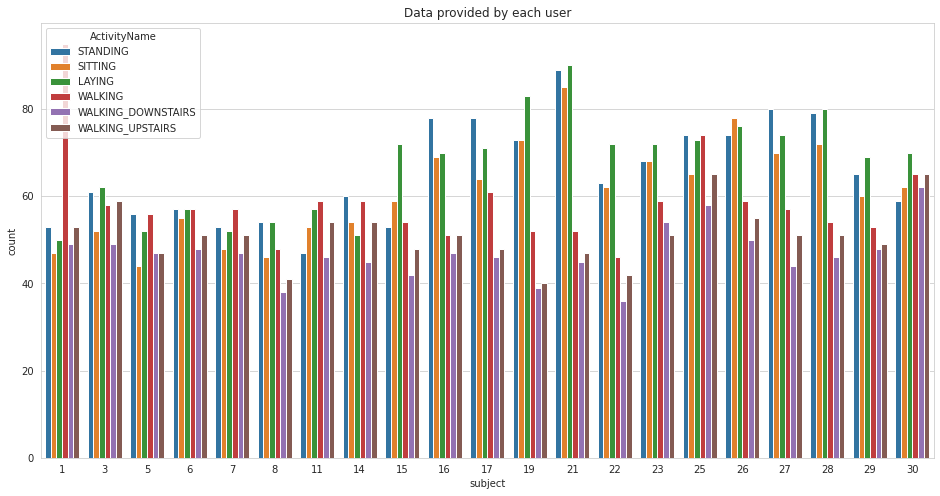

In [58]:
sns.set_style("whitegrid")
plt.figure(figsize=(16, 8))
plt.title("Data provided by each user")
sns.countplot(x = "subject", hue = "ActivityName", data = train)
plt.show()

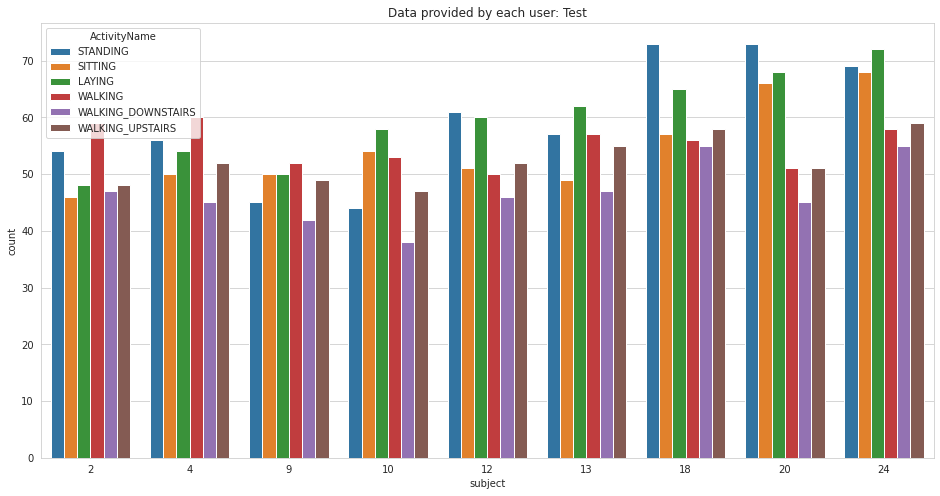

In [59]:
sns.set_style("whitegrid")
plt.figure(figsize=(16, 8))
plt.title("Data provided by each user: Test")
sns.countplot(x = "subject", hue = "ActivityName", data = test)
plt.show()

Similar readings from all users

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


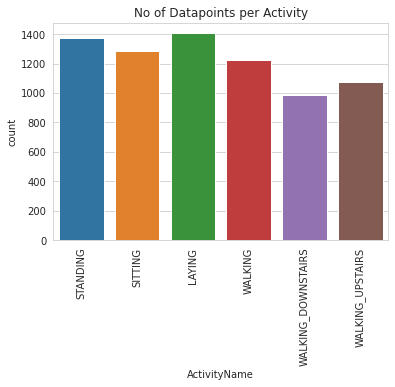

In [62]:
plt.title('No of Datapoints per Activity')
sns.countplot(train.ActivityName)
plt.xticks(rotation=90)
plt.show()

Decently Balanced Data

### Changning Feature Names

In [63]:
columns = train.columns

columns = columns.str.replace('[()]', '')
columns = columns.str.replace('[-]', '')
columns = columns.str.replace('[,]', '')

train.columns = columns
test.columns = columns

test.columns

Index(['tBodyAccmeanX', 'tBodyAccmeanY', 'tBodyAccmeanZ', 'tBodyAccstdX',
       'tBodyAccstdY', 'tBodyAccstdZ', 'tBodyAccmadX', 'tBodyAccmadY',
       'tBodyAccmadZ', 'tBodyAccmaxX',
       ...
       'angletBodyAccMeangravity', 'angletBodyAccJerkMeangravityMean',
       'angletBodyGyroMeangravityMean', 'angletBodyGyroJerkMeangravityMean',
       'angleXgravityMean', 'angleYgravityMean', 'angleZgravityMean',
       'subject', 'Activity', 'ActivityName'],
      dtype='object', length=564)

### Saving dataset to a file.

In [64]:
train.to_csv("/content/drive/MyDrive/AAIC/Case Studies/Human Activity Recognition/train.csv", index = False)
test.to_csv("/content/drive/MyDrive/AAIC/Case Studies/Human Activity Recognition/test.csv", index = False)

## Exploratory Data Analysis

Two types of activities

1. Static. Where there is no movement in the user.
2. Dynamic. Where there is significant movement in the user. 

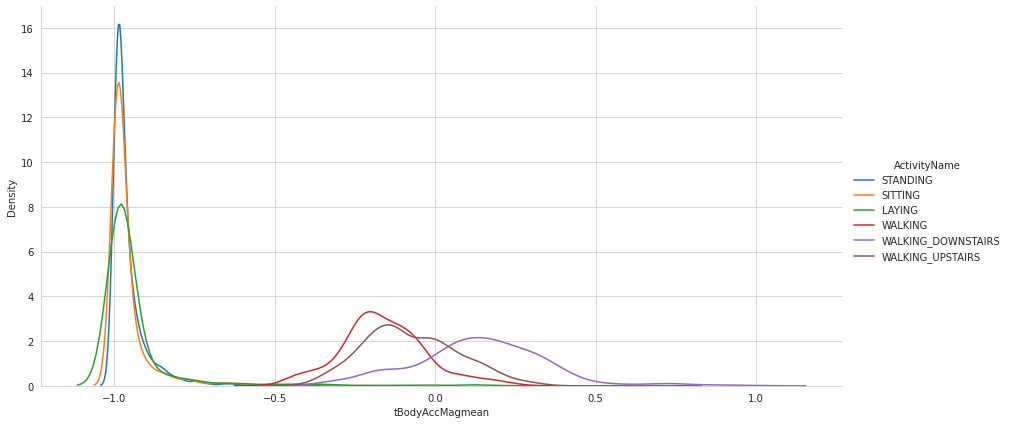

In [71]:
facetgrid = sns.FacetGrid(train, size = 6, aspect = 2, hue = "ActivityName")
facetgrid.map(sns.distplot, 'tBodyAccMagmean', hist = False).add_legend()
plt.show()

The spike seen on the left is stationary activities as a result of which tBodyAccMagmean ie., spread is low. The smaller spike is of dynammic activities whose spread is high.